In [1]:
import pandas as pd
import os
import sys
sys.path.append('..')  # add parent directory to path to import utils
from utils import set_plots_size_params, reg_plot
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
types = pd.read_csv('../data/mutation_types_short.csv')

In [3]:
types.loc[types.Pos==1649]

,Pos,Ref,Base,complement,protein,start,end,mutation_type
4488,1649,T,A,False,cp,1335,1727,NaN
4489,1649,T,C,False,cp,1335,1727,NaN
4490,1649,T,G,False,cp,1335,1727,I105M


In [4]:
types.loc[types.Pos==1691]

,Pos,Ref,Base,complement,protein,start,end,mutation_type
4653,1691,T,A,False,cp,1335,1727,NaN
4654,1691,T,C,False,cp,1335,1727,NaN
4655,1691,T,G,False,cp,1335,1727,I119M
4656,1691,T,A,False,lys,1678,1905,F5Y
4657,1691,T,C,False,lys,1678,1905,F5S
4658,1691,T,G,False,lys,1678,1905,F5C


In [5]:
types.loc[types.Pos==1685]

,Pos,Ref,Base,complement,protein,start,end,mutation_type
4617,1685,C,A,False,cp,1335,1727,N117K
4618,1685,C,T,False,cp,1335,1727,NaN
4619,1685,C,G,False,cp,1335,1727,N117K
4620,1685,C,A,False,lys,1678,1905,T3N
4621,1685,C,T,False,lys,1678,1905,T3I
4622,1685,C,G,False,lys,1678,1905,T3S


In [6]:
types.loc[types.Pos==1697]

,Pos,Ref,Base,complement,protein,start,end,mutation_type
4689,1697,A,C,False,cp,1335,1727,NaN
4690,1697,A,T,False,cp,1335,1727,NaN
4691,1697,A,G,False,cp,1335,1727,NaN
4692,1697,A,C,False,lys,1678,1905,Q7P
4693,1697,A,T,False,lys,1678,1905,Q7L
4694,1697,A,G,False,lys,1678,1905,Q7R


In [7]:
ifreqs = pd.read_csv("../data/illumina_newpipe_freqs.csv")
lfreqs = pd.read_csv('../data/new_loop_freqs.csv')

In [8]:
def get_mutation_data(freqs):
    mutation_data = freqs[(freqs.frequency>0.001) & (freqs.frequency<0.5) & (freqs.coverage>50) & 
                          (freqs.ref_pos>23) & (freqs.ref_pos<=3541)].copy()
    return mutation_data

In [9]:
imutation = get_mutation_data(ifreqs)
lmutation = get_mutation_data(lfreqs)

In [10]:
imutation['source'] = 'illumina'
lmutation['source'] = 'loop'

In [11]:
mutations = pd.concat([lmutation,imutation])

In [12]:
set_plots_size_params(30)

In [13]:
def mutations_box_plots(data, title, log_scale, save_fig_path=None):
    fig, axes = plt.subplots(figsize=(60, 15), ncols=3, nrows=1)
    plt.suptitle(title, fontsize=32)
    plt.subplots_adjust(wspace=0.4, hspace=0.3)
    for i in range(3):
        km_muts = data[data.km==i+1]
        daplot = sns.boxplot(data=km_muts, x='passage', y='frequency', hue='source', ax=axes[i], showmeans=True,
                             meanprops={"markersize":10, "marker":"o" ,"markerfacecolor":"red", "markeredgecolor":"red"})
        daplot.set_title(f"Mutations in Line {i+1}")
        if log_scale:
            daplot.set_yscale('log')
        if save_fig_path:
            fig.savefig(save_fig_path) 
    return daplot

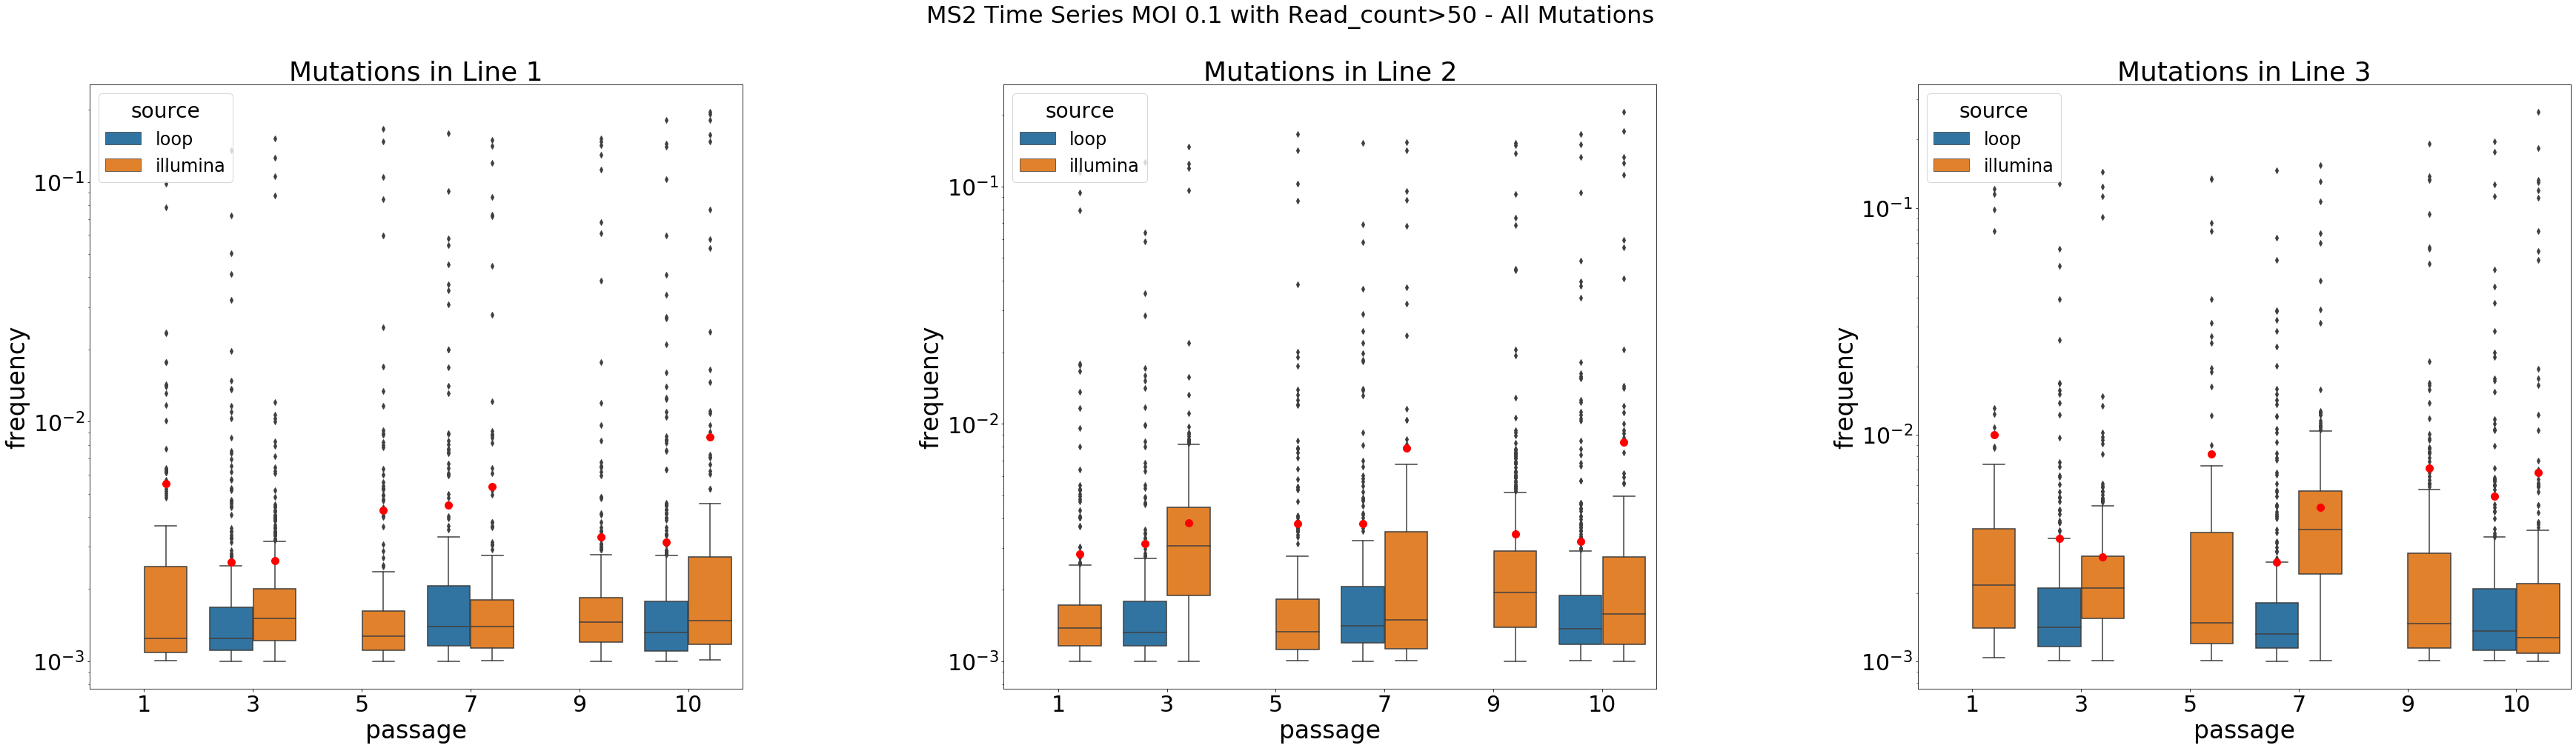

In [14]:
mutations_box_plots(mutations, 
                    "MS2 Time Series MOI 0.1 with Read_count>50 - All Mutations", 
                    log_scale=True)

## Rather concerning but if we filter out oxidation mutations:

In [15]:
def is_oxidation(row):
    if (row.ref_base=="C" and row.read_base=='A') or (row.ref_base=='G' and row.read_base=='T'):
        return True
    return False

In [16]:
mutations['oxidation'] = mutations.apply(is_oxidation, axis=1)

In [17]:
not_oxidation = mutations[~mutations.oxidation]

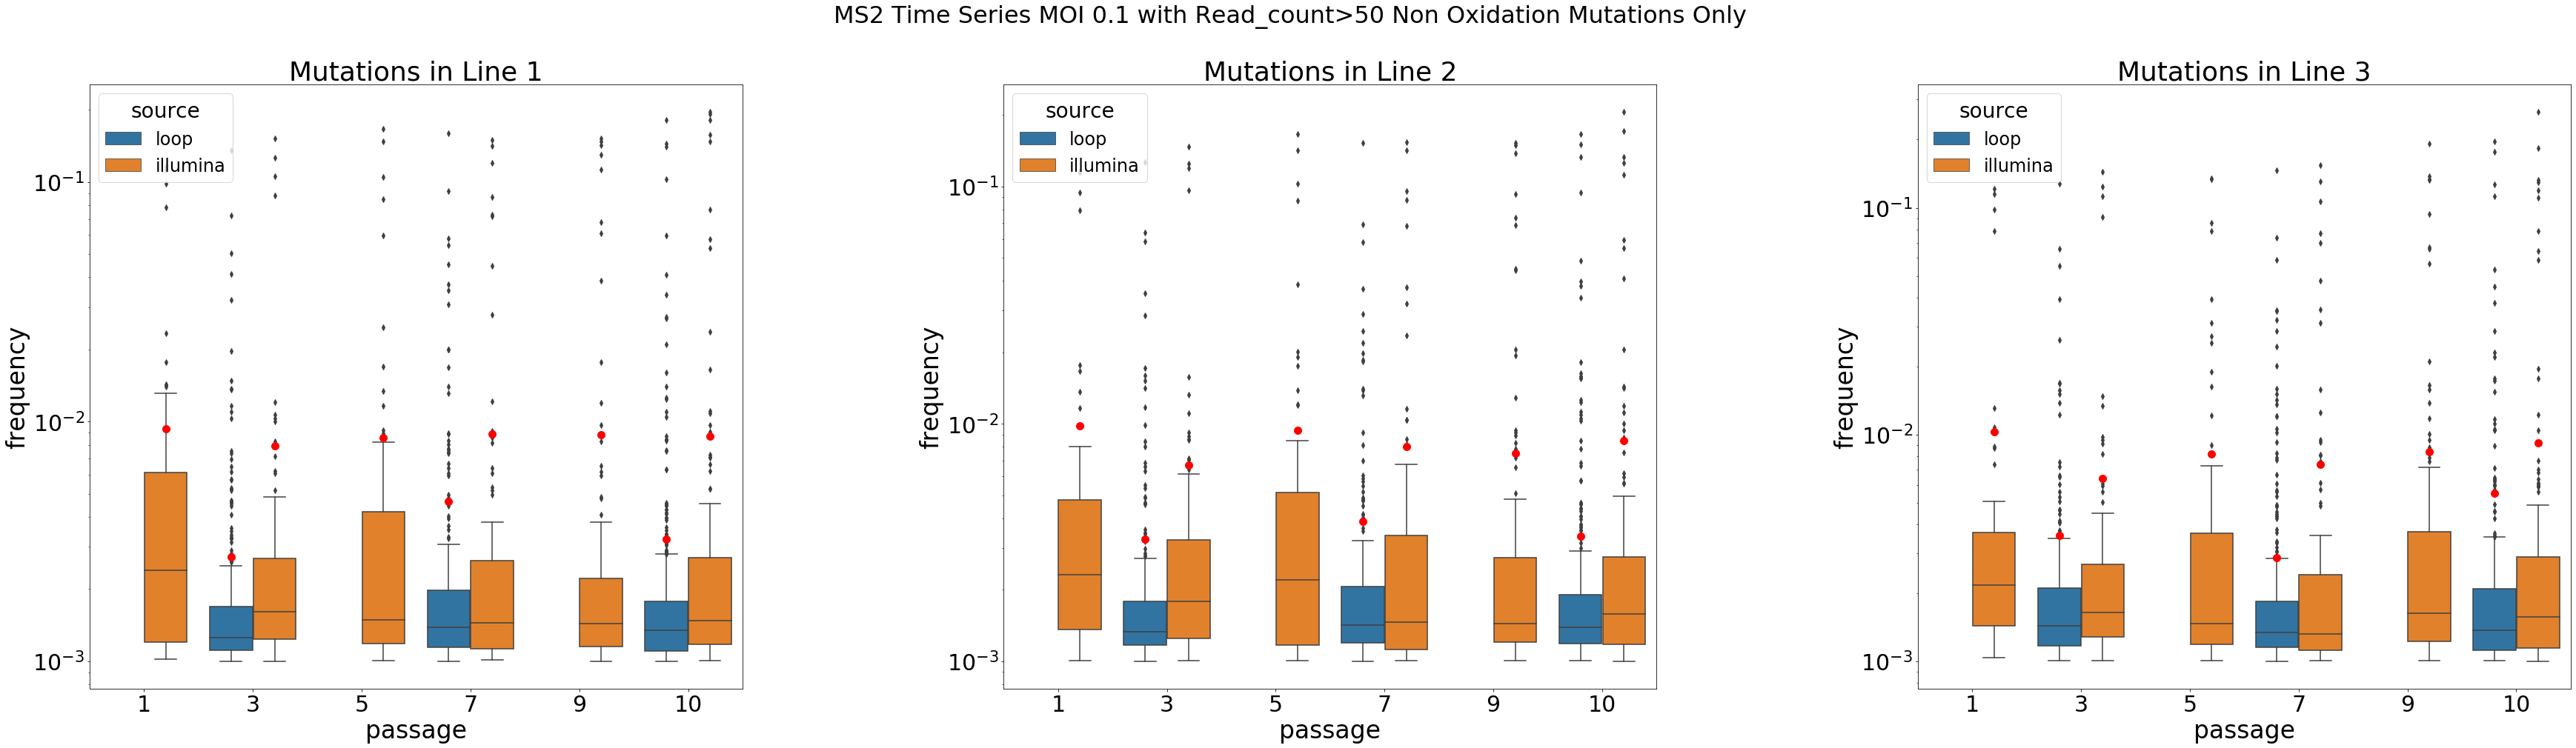

In [18]:
mutations_box_plots(not_oxidation, 
                    "MS2 Time Series MOI 0.1 with Read_count>50 Non Oxidation Mutations Only", 
                    log_scale=True)

# What's with the differences between loop and illumina?

In [19]:
mutations.source.value_counts()

illumina    7187
loop        3206
Name: source, dtype: int64

In [36]:
rel_pas = [3,7,10]
rel_illum = not_oxidation[(not_oxidation.passage.isin(rel_pas)) & (not_oxidation.source=='illumina')]
rel_loop = not_oxidation[(not_oxidation.passage.isin(rel_pas)) & (not_oxidation.source=='loop')]
boxplots = pd.DataFrame()
boxplots['loop'] = rel_loop.groupby(['km','passage']).ref_pos.count()
boxplots['illumina'] = rel_illum.groupby(['km','passage']).ref_base.count()
boxplots['joint'] = mutations_in_both.groupby(['km','passage']).read_base.count()

Text(0.5, 1.0, 'Non Oxidation Mutations per Dataset')

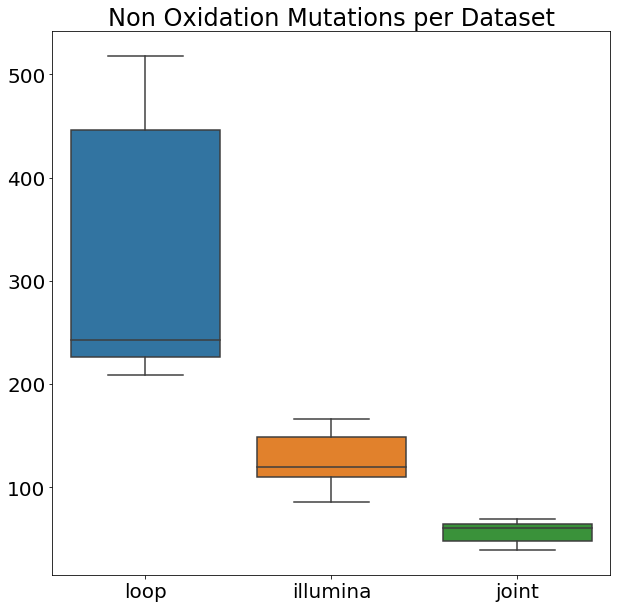

In [37]:
plt.figure(figsize=(10,10))
daplot = sns.boxplot(data=boxplots)
daplot.set_title('Non Oxidation Mutations per Dataset')

In [38]:
#daplot.figure.savefig('non oxidation mutations per dataset.png')

In [20]:
loop = mutations[(mutations.source=='loop')]
illumina = mutations[(mutations.source=='illumina')]

In [21]:
def create_pivot_table(df):
    pivot_table = pd.DataFrame(df.groupby(['ref_base']).read_base.value_counts()).rename(
        columns={'read_base': 'count'}).reset_index()
    pivot_table = pivot_table.pivot(index='ref_base', columns='read_base', values='count')
    return pivot_table

Text(0.5, 1, 'Illumina Data')

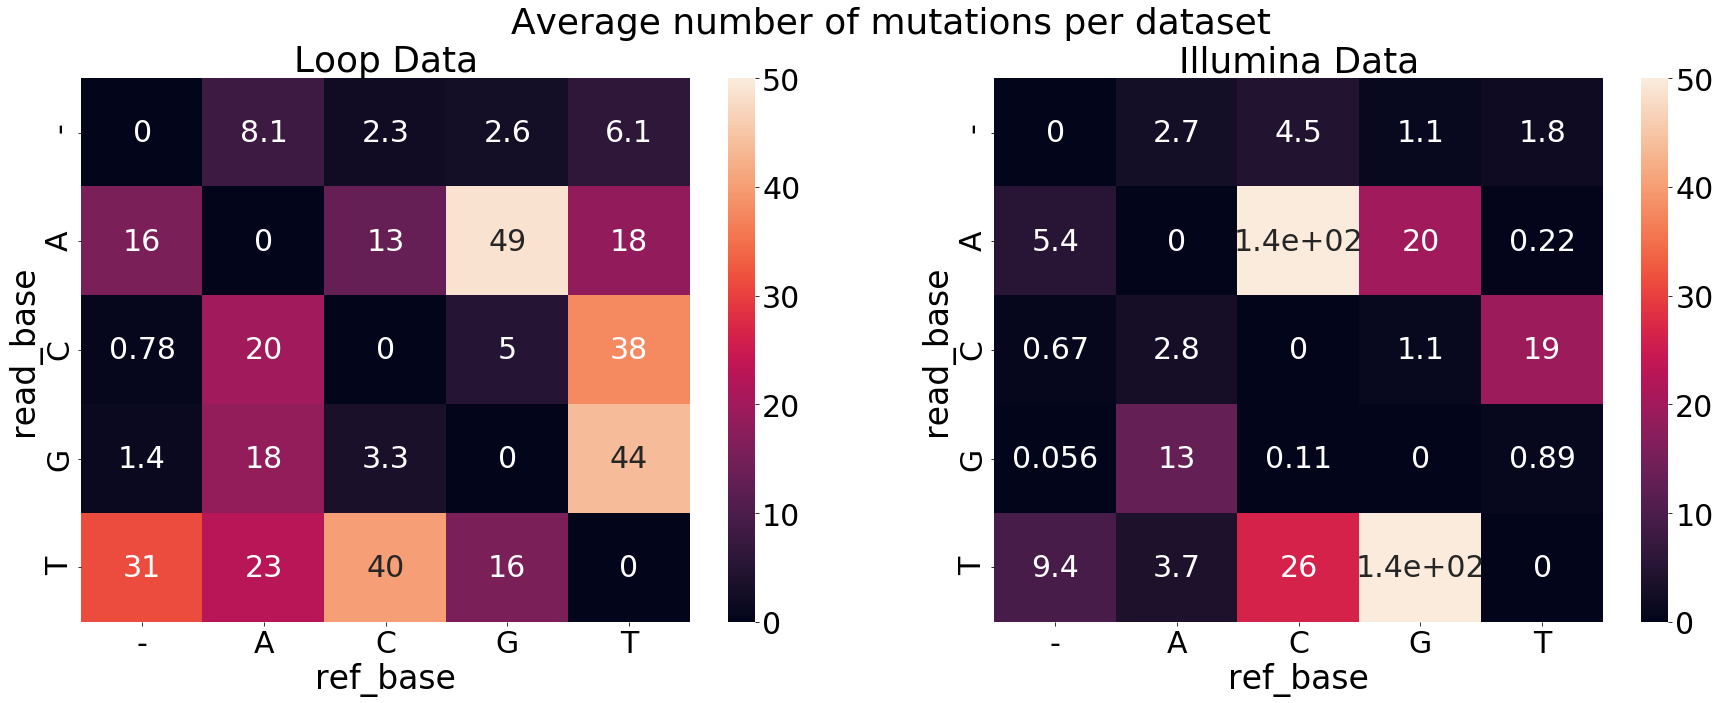

In [22]:
fig, axes = plt.subplots(figsize=(30, 10), ncols=2, nrows=1)
plt.suptitle("Average number of mutations per dataset")
sns.heatmap((create_pivot_table(loop)/9).fillna(0).T, annot=True, ax=axes[0], vmax=50)
axes[0].set_title('Loop Data')
sns.heatmap((create_pivot_table(illumina)/18).fillna(0).T, annot=True, ax=axes[1], vmax=50)
axes[1].set_title('Illumina Data')

In [23]:
#fig.savefig('loop vs illumina heatmaps.png')

### Loop doesn't seem to have oxidation issues..

In [24]:
not_oxidation.source.value_counts()

loop        2945
illumina    2043
Name: source, dtype: int64

source
illumina    AxesSubplot(0.125,0.125;0.775x0.755)
loop        AxesSubplot(0.125,0.125;0.775x0.755)
Name: frequency, dtype: object

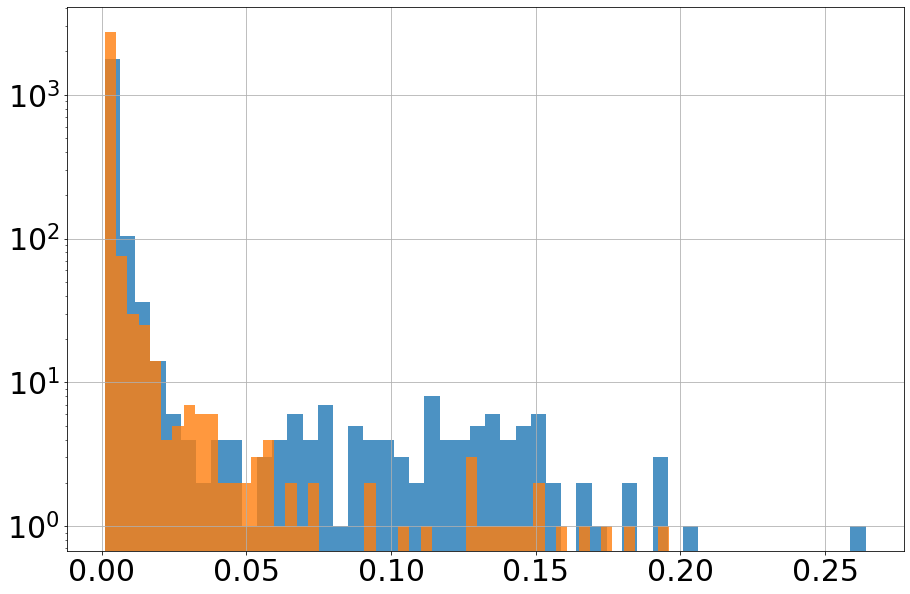

In [25]:
plt.figure(figsize=(15,10))
not_oxidation.groupby('source').frequency.hist(bins=50, log=True, alpha=0.8)

## Let's take a look at the high frequency mutations:

In [26]:
not_oxidation[not_oxidation.frequency>0.05].source.value_counts()

illumina    98
loop        33
Name: source, dtype: int64

In [27]:
top_mutations = not_oxidation[not_oxidation.frequency>0.05].groupby('source').ref_pos.value_counts()
top_mutations

source    ref_pos 
illumina  224.000     18
          1554.000    18
          3299.000    18
          522.000     16
          1691.000    10
          1685.000     7
          1697.000     6
          1649.000     4
          1593.000     1
loop      3299.000     9
          1007.001     8
          1691.000     6
          1554.000     4
          1685.000     3
          1697.000     3
Name: ref_pos, dtype: int64

224.0


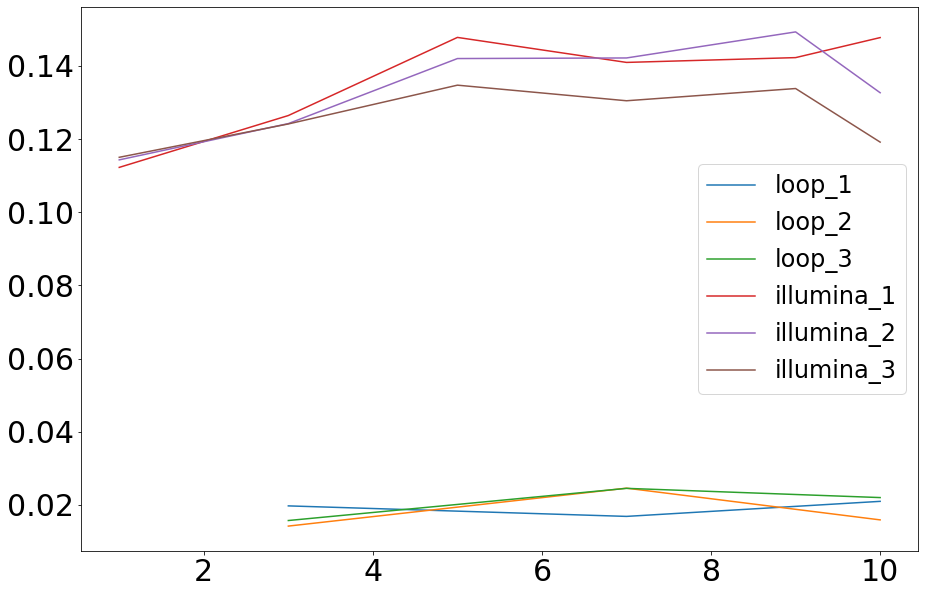

1554.0


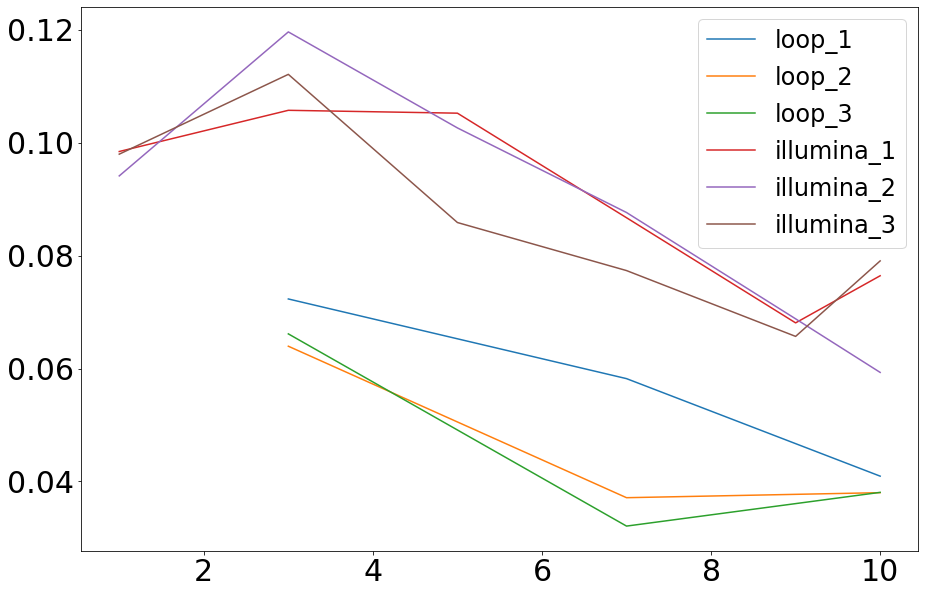

3299.0


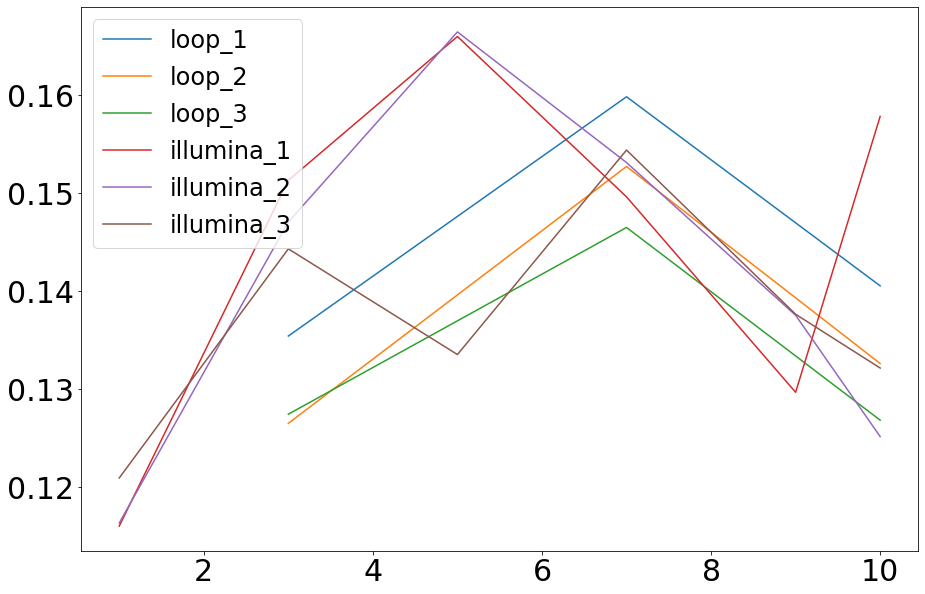

522.0


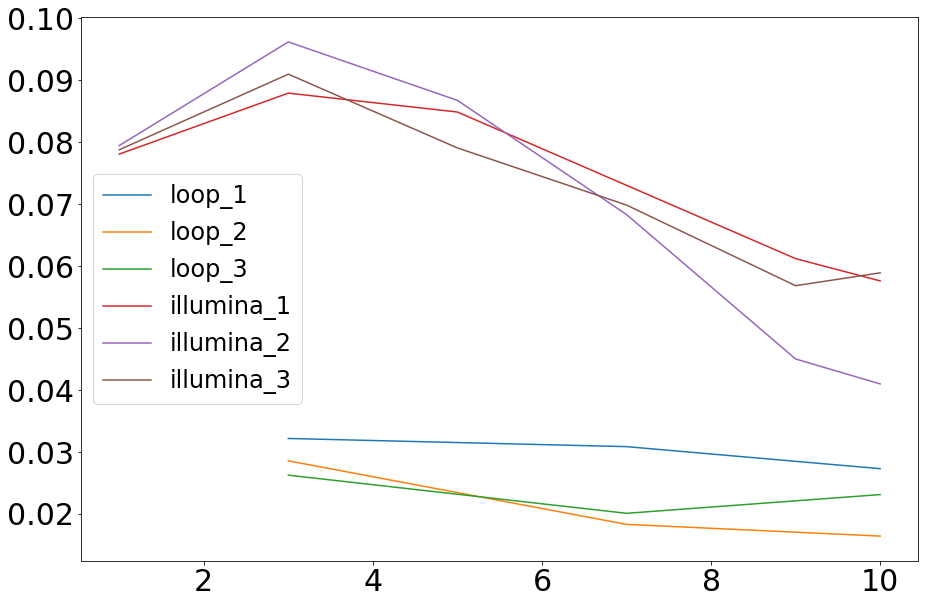

1691.0


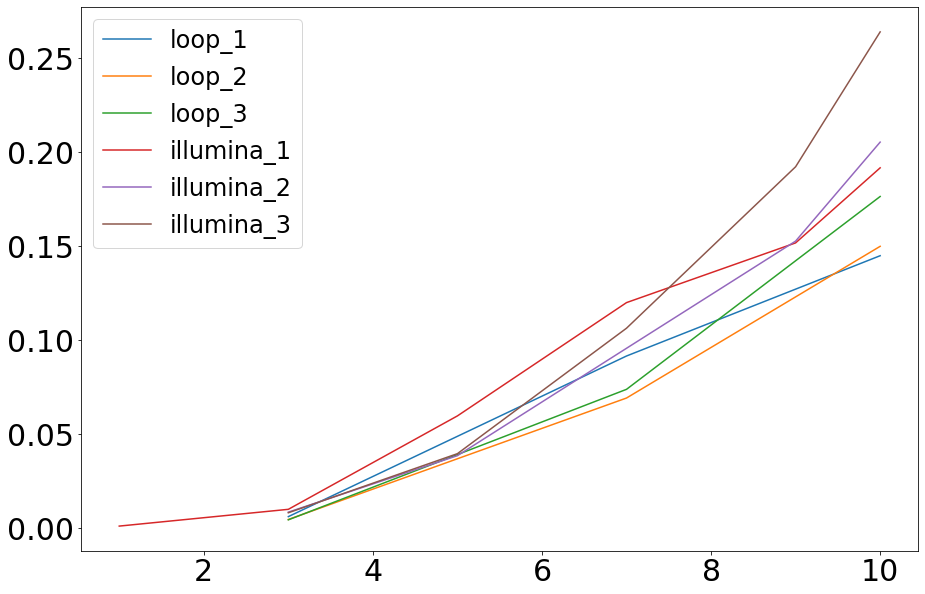

1685.0


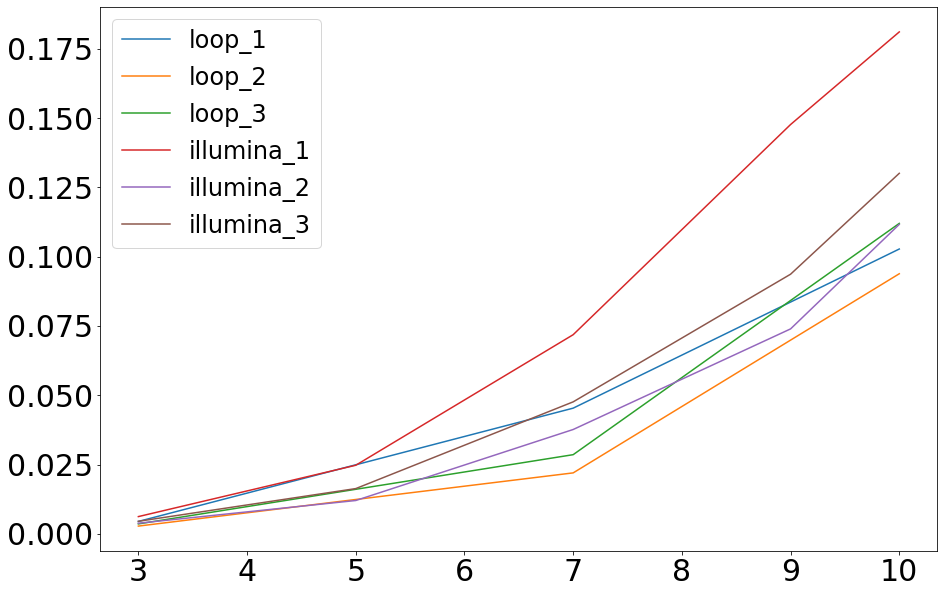

1697.0


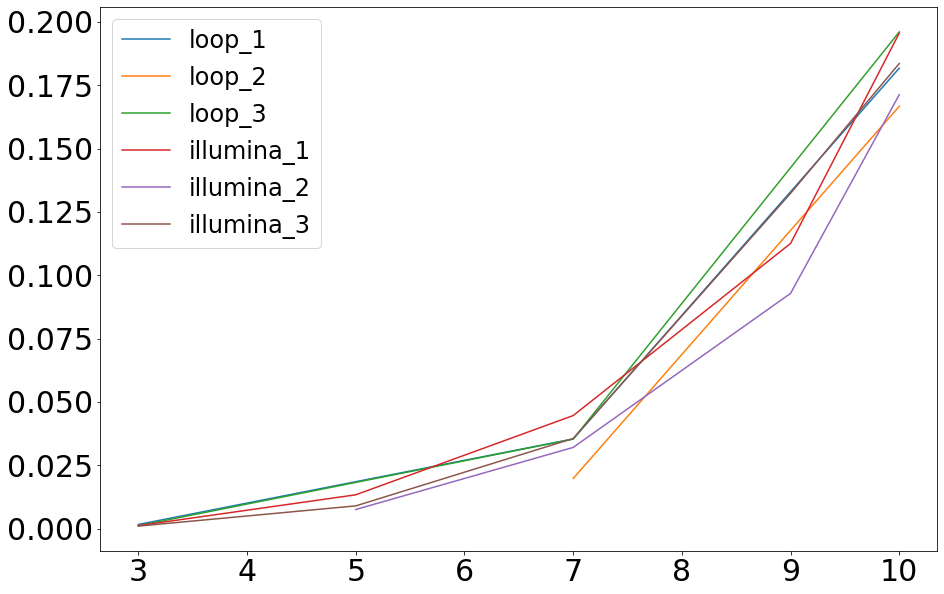

1649.0


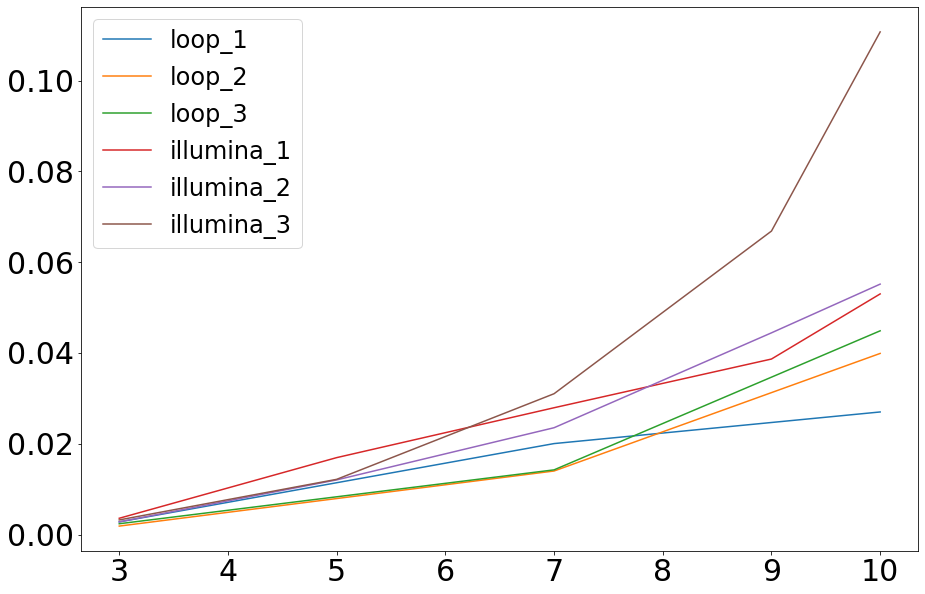

1593.0


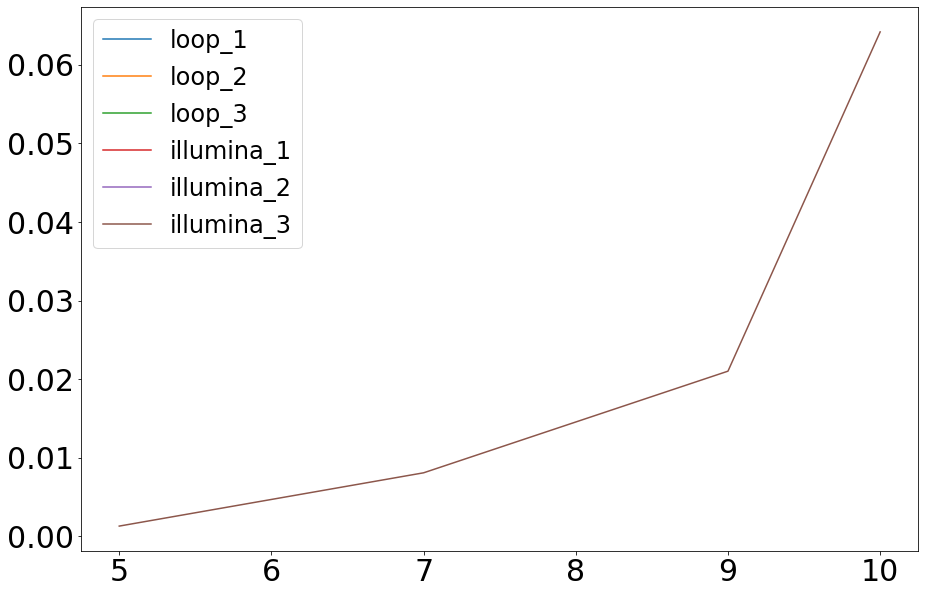

3299.0


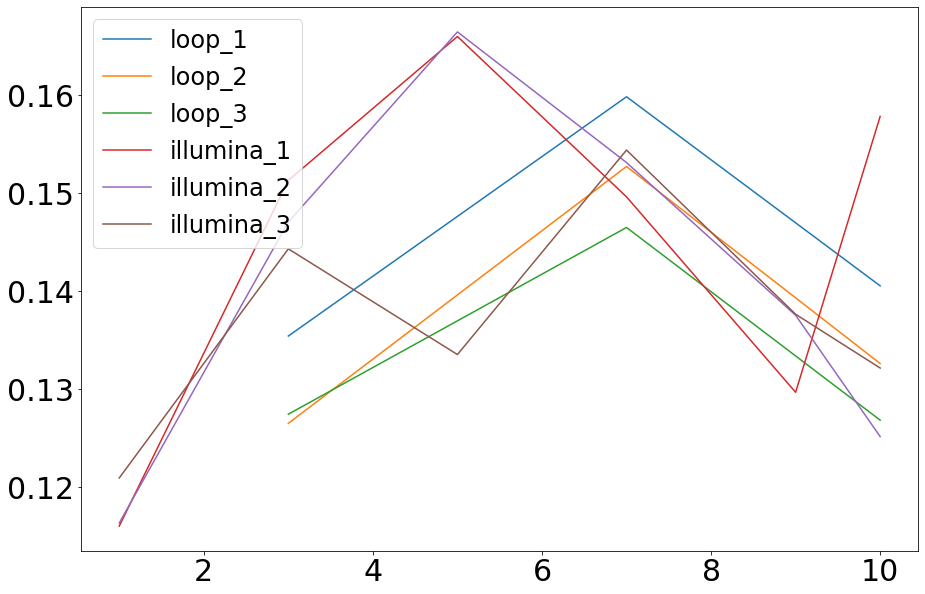

1007.001


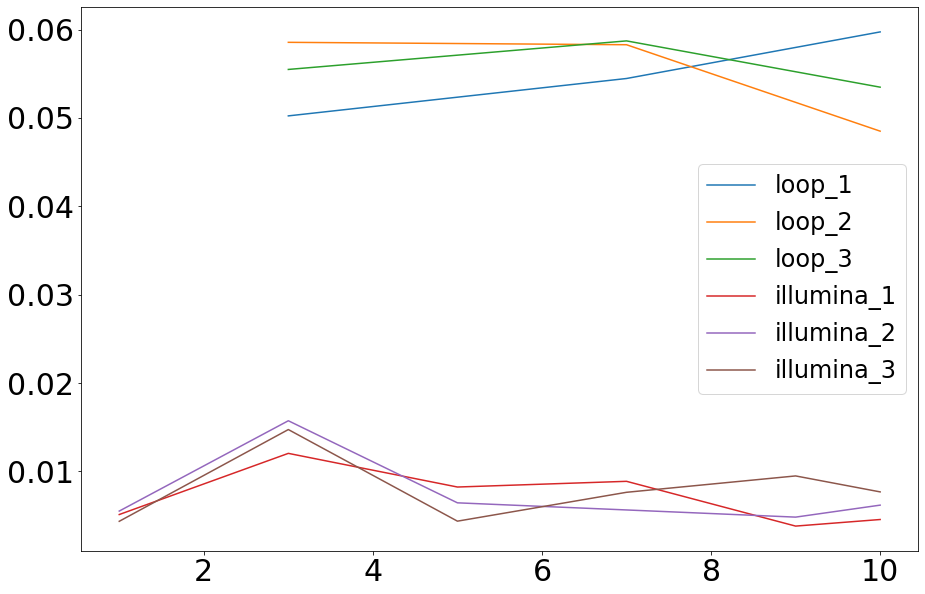

1691.0


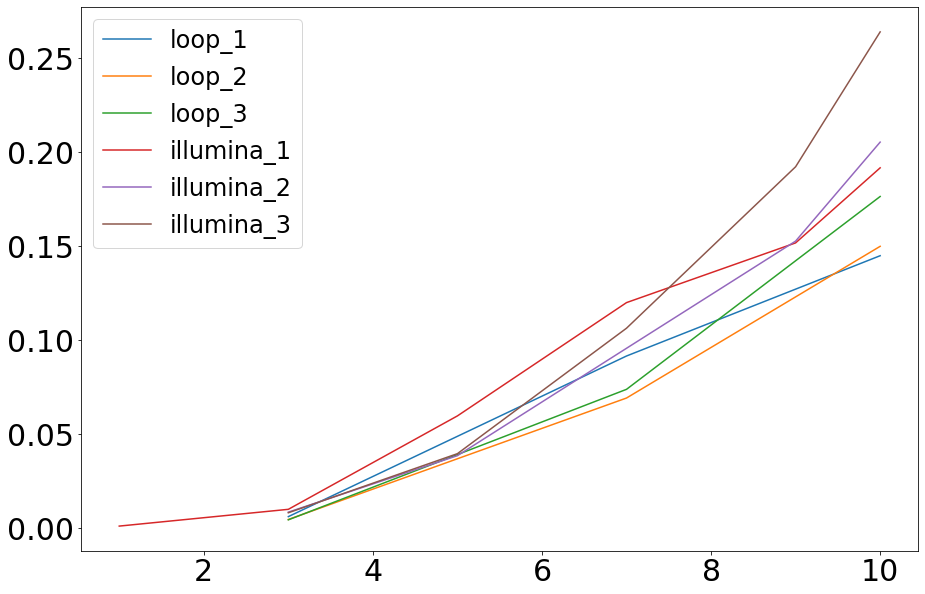

1554.0


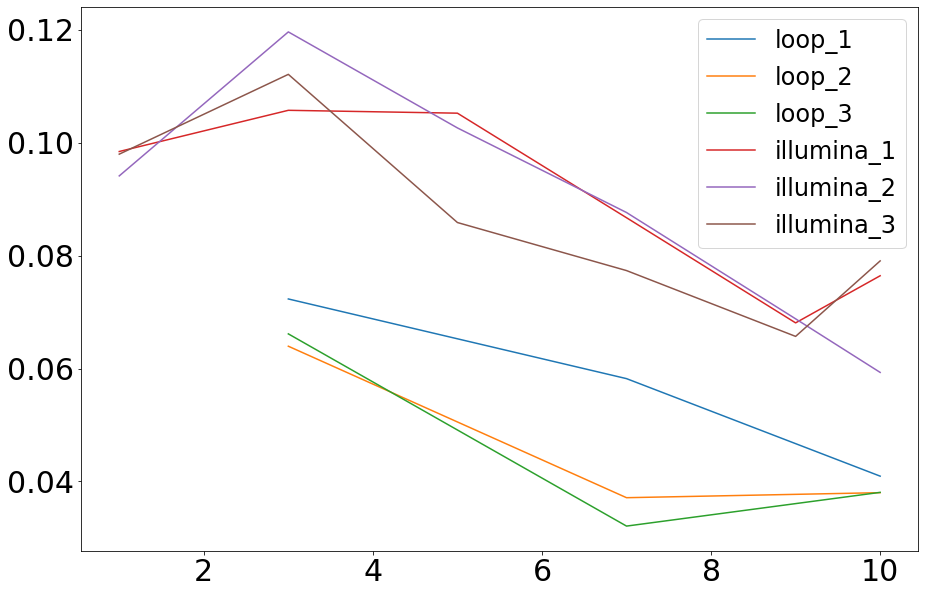

1685.0


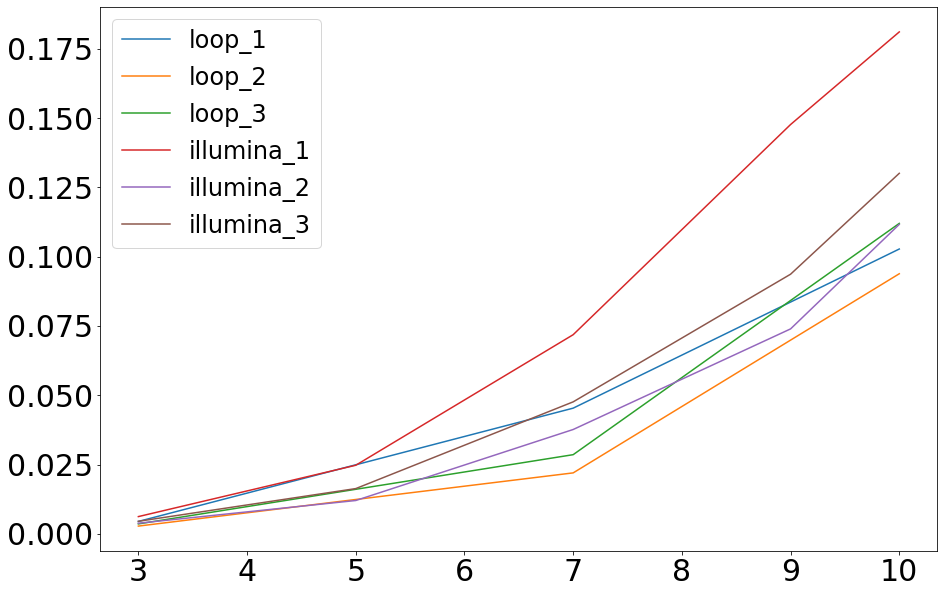

1697.0


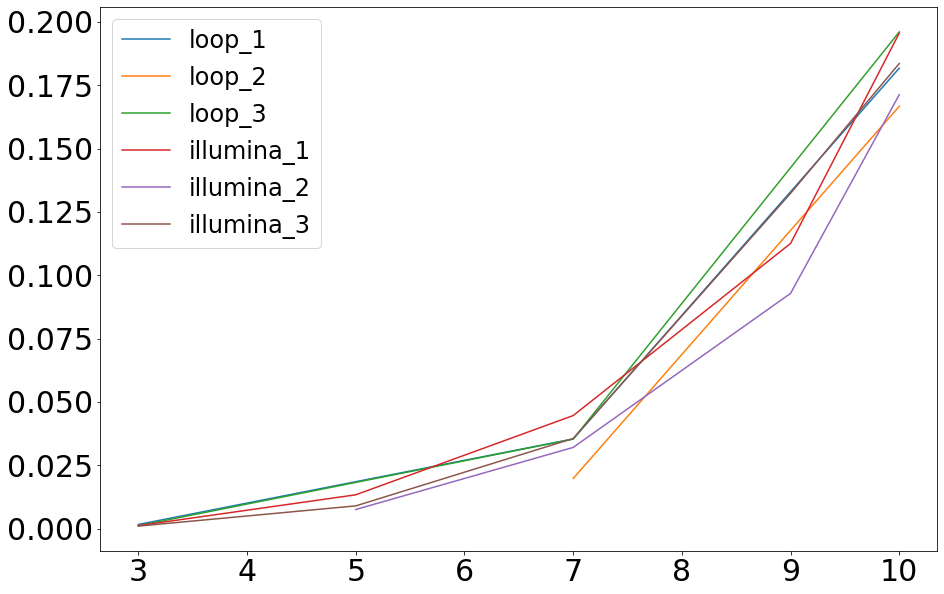

In [28]:
top_mutations_positions = top_mutations.index.get_level_values(1)
for pos in top_mutations_positions:
    print(pos)
    plt.figure(figsize=(15,10))
    df = mutations[mutations.ref_pos==pos].sort_values(by=['passage', 'km', 'source'])
    if pos==224:
        df = df[df.read_base=="T"]
    if pos==1554 or pos==522:
        df = df[df.read_base=="A"]
    for src in mutations.source.unique():
        tmp = df[df.source==src]
        for km in mutations.km.unique():
            tmp2 = tmp[tmp.km==km]
            plt.plot(tmp2.passage, tmp2.frequency, label=src+"_"+str(km))
    plt.legend()
    plt.show()

## And at the rest of the mutataions:

In [29]:
mutations[mutations.frequency<0.05].source.value_counts()

illumina    7089
loop        3173
Name: source, dtype: int64

In [30]:
not_oxidation[not_oxidation.frequency<0.05].source.value_counts()

loop        2912
illumina    1945
Name: source, dtype: int64

## just 513 mutations are in both data sets... Let's see if they agree:

In [31]:
mutations_in_both = mutations[mutations.duplicated(['km','passage','ref_pos','read_base'], keep=False)].sort_values(by=['ref_pos','source']).copy()
mutations_in_both = mutations_in_both[mutations_in_both.source=='illumina'].merge(
    mutations_in_both[mutations_in_both.source=='loop'], on=['km','passage','ref_pos','read_base','ref_base'], 
    suffixes=('_i','_l'))[['ref_pos', 'read_base', 'ref_base', 'km','passage',
                           'base_count_i', 'coverage_i', 'frequency_i', 'base_rank_i', 
                           'base_count_l', 'coverage_l', 'frequency_l', 'base_rank_l']]
mutations_in_both['freq_ratio'] = mutations_in_both['frequency_i'] / mutations_in_both['frequency_l']

In [32]:
mutations_in_both.sort_values(by='freq_ratio', ascending=False)

,ref_pos,read_base,ref_base,km,passage,base_count_i,coverage_i,frequency_i,base_rank_i,base_count_l,coverage_l,frequency_l,base_rank_l,freq_ratio
510,3506.000,A,C,3,7,220.0,22652.0,0.009712,1.0,2.0,1827.0,0.001095,1.0,8.872064
96,1004.001,T,-,1,3,2146.0,207826.0,0.010326,0.0,2.0,1704.0,0.001174,0.0,8.797706
20,224.000,T,C,2,3,20822.0,167593.0,0.124241,1.0,37.0,2610.0,0.014176,1.0,8.764060
18,224.000,T,C,1,7,19747.0,140079.0,0.140970,1.0,73.0,4338.0,0.016828,1.0,8.377121
22,224.000,T,C,2,10,12751.0,96105.0,0.132678,1.0,19.0,1197.0,0.015873,1.0,8.358701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,1007.001,T,-,1,10,896.0,196854.0,0.004552,0.0,108.0,1808.0,0.059735,0.0,0.076197
379,2739.001,A,-,1,7,128.0,97079.0,0.001319,0.0,136.0,6816.0,0.019953,0.0,0.066081
384,2739.001,A,-,3,10,196.0,174747.0,0.001122,0.0,83.0,4704.0,0.017645,0.0,0.063568
382,2739.001,A,-,2,10,74.0,66999.0,0.001104,0.0,36.0,1985.0,0.018136,0.0,0.060901


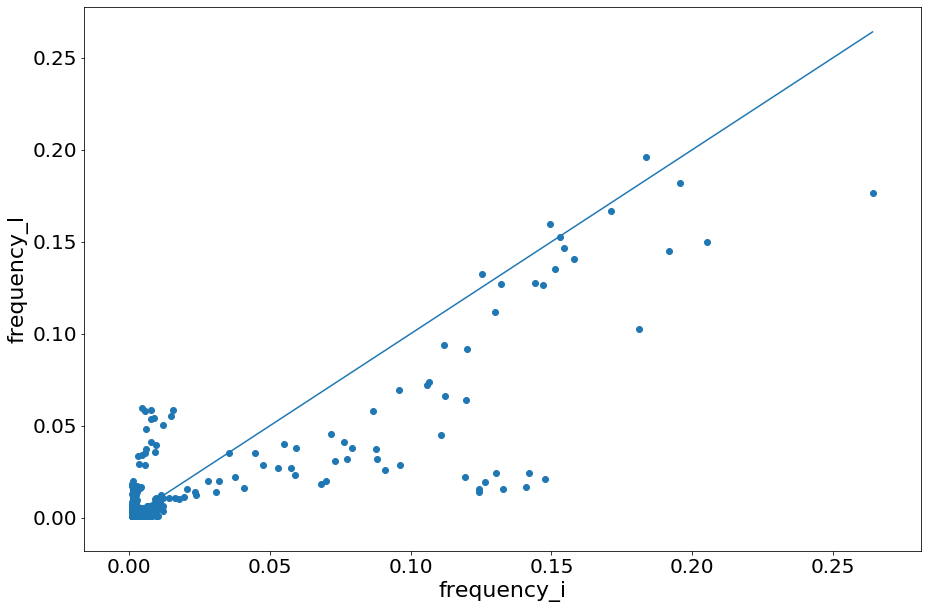

In [33]:
reg_plot(mutations_in_both.frequency_i, mutations_in_both.frequency_l, save_to='mutations freq regplot.png')

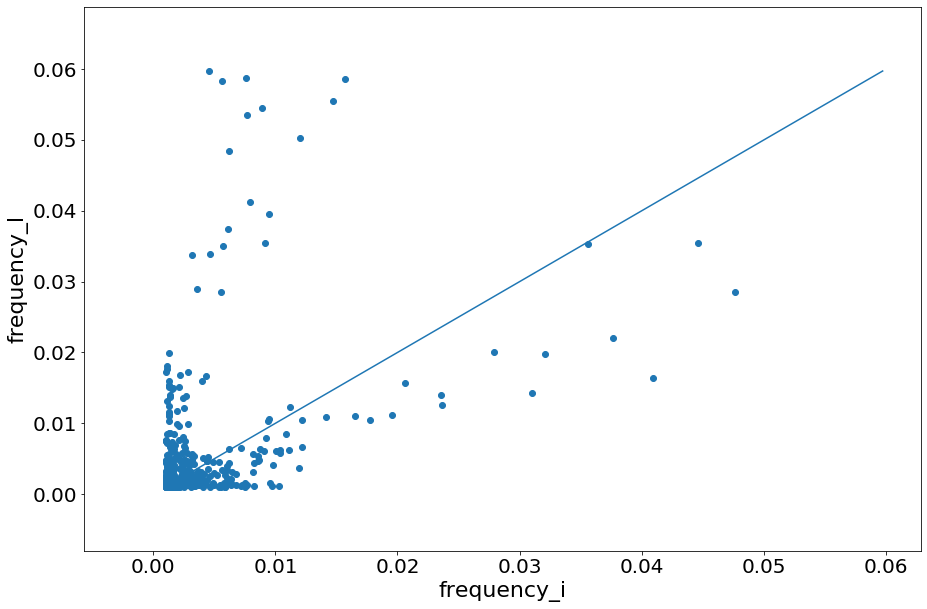

In [34]:
temp = mutations_in_both[mutations_in_both.frequency_i<0.05]
reg_plot(temp.frequency_i, temp.frequency_l)

## Comparing just synonumous mutations

In [42]:
coding_or_syn = types.set_index(['Pos','Base']).index
coding_muts = types[types.mutation_type.notna()].set_index(['Pos', 'Base']).index
non_coding_and_syns = mutations[mutations.apply(lambda row: 
                                                (row.ref_pos, row.read_base) not in coding_muts, axis=1)]
just_syn = non_coding_and_syns[non_coding_and_syns.apply(lambda row: 
                                                         (row.ref_pos, row.read_base) in coding_or_syn, axis=1)]

/home/itush/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


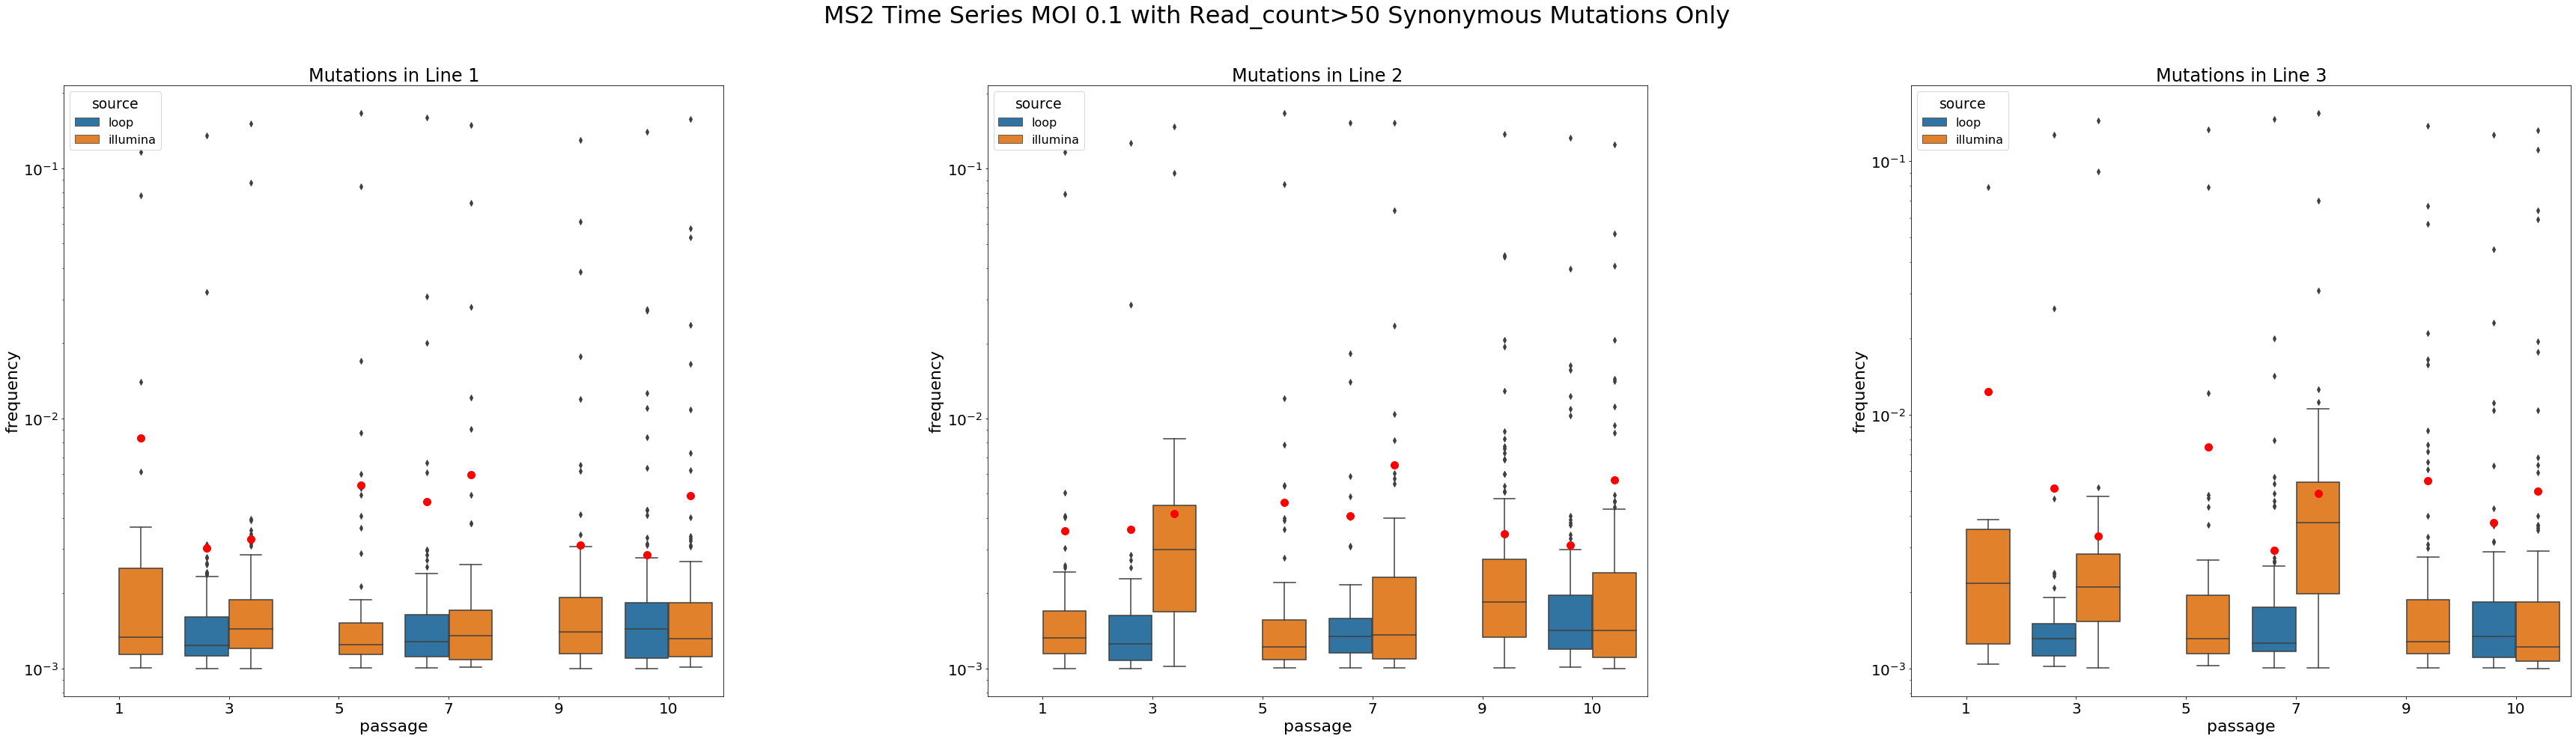

In [57]:
mutations_box_plots(just_syn, 
                    "MS2 Time Series MOI 0.1 with Read_count>50 Synonymous Mutations Only", 
                    log_scale=True)

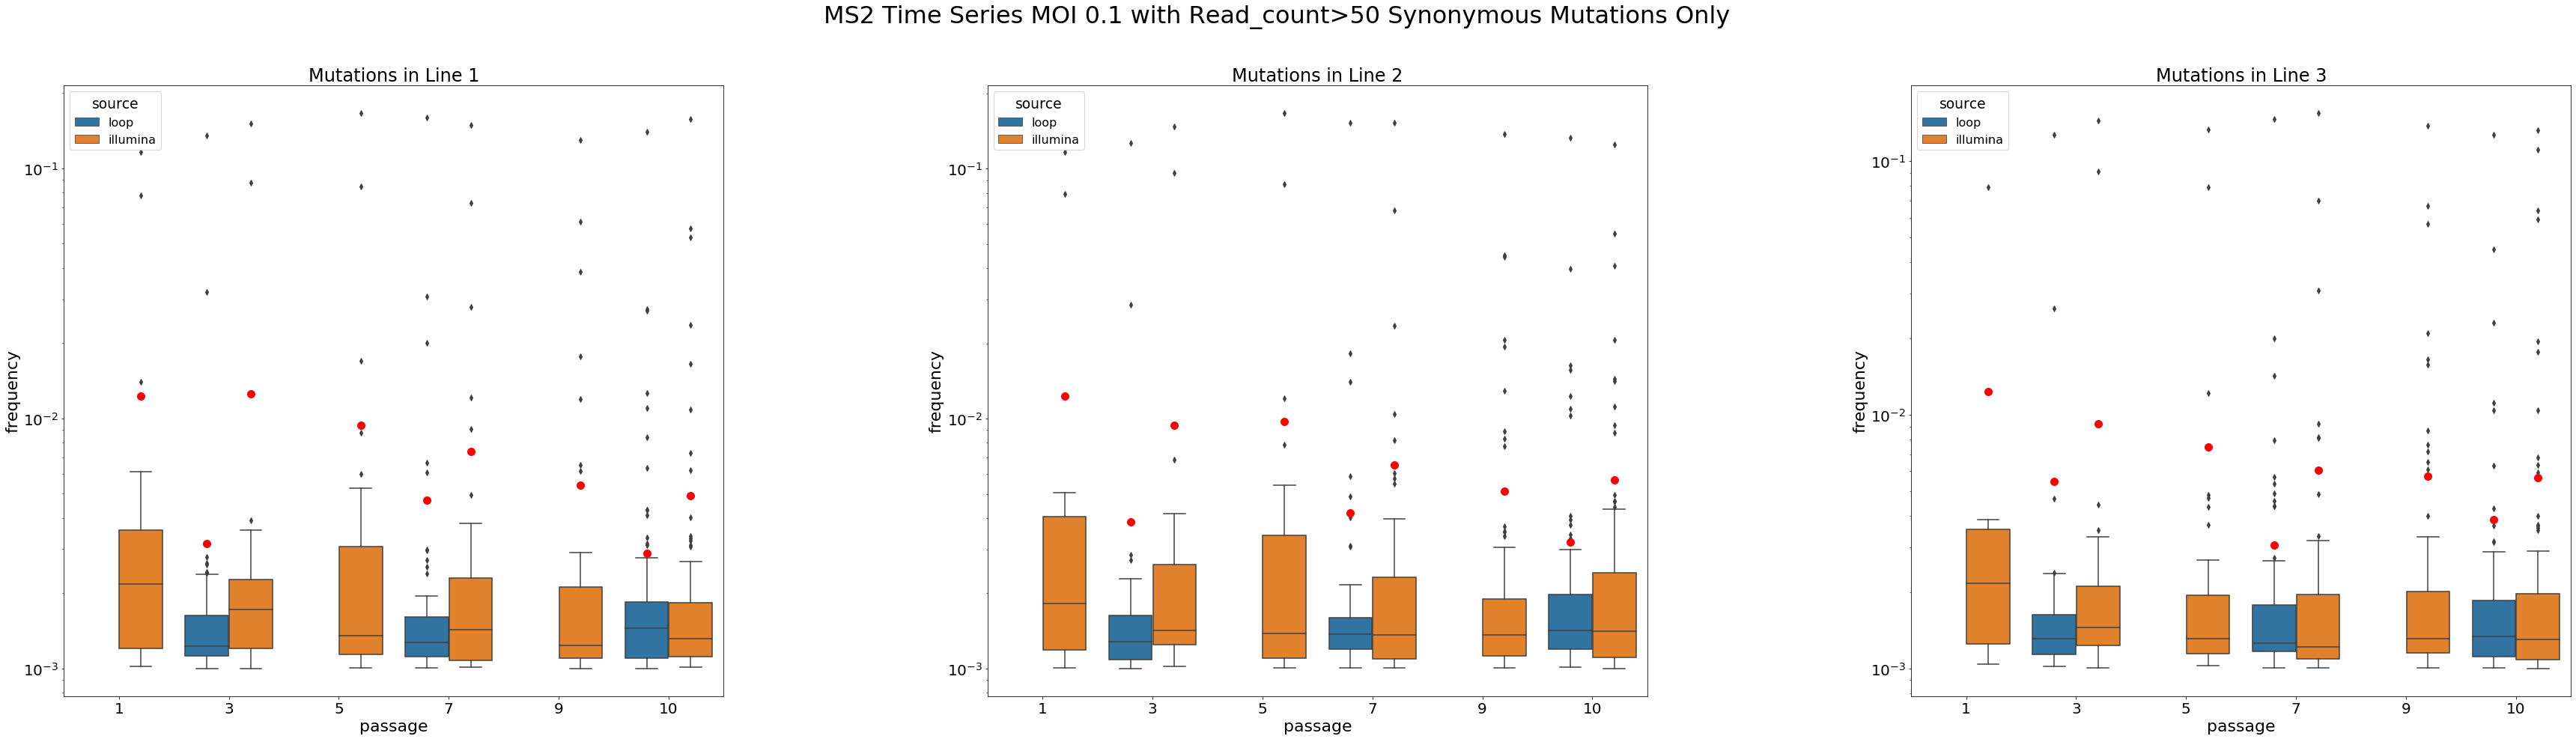

In [67]:
mutations_box_plots(just_syn[~just_syn.oxidation], 
                    "MS2 Time Series MOI 0.1 with Read_count>50 Non Oxidation Synonymous Mutations Only", 
                    log_scale=True)

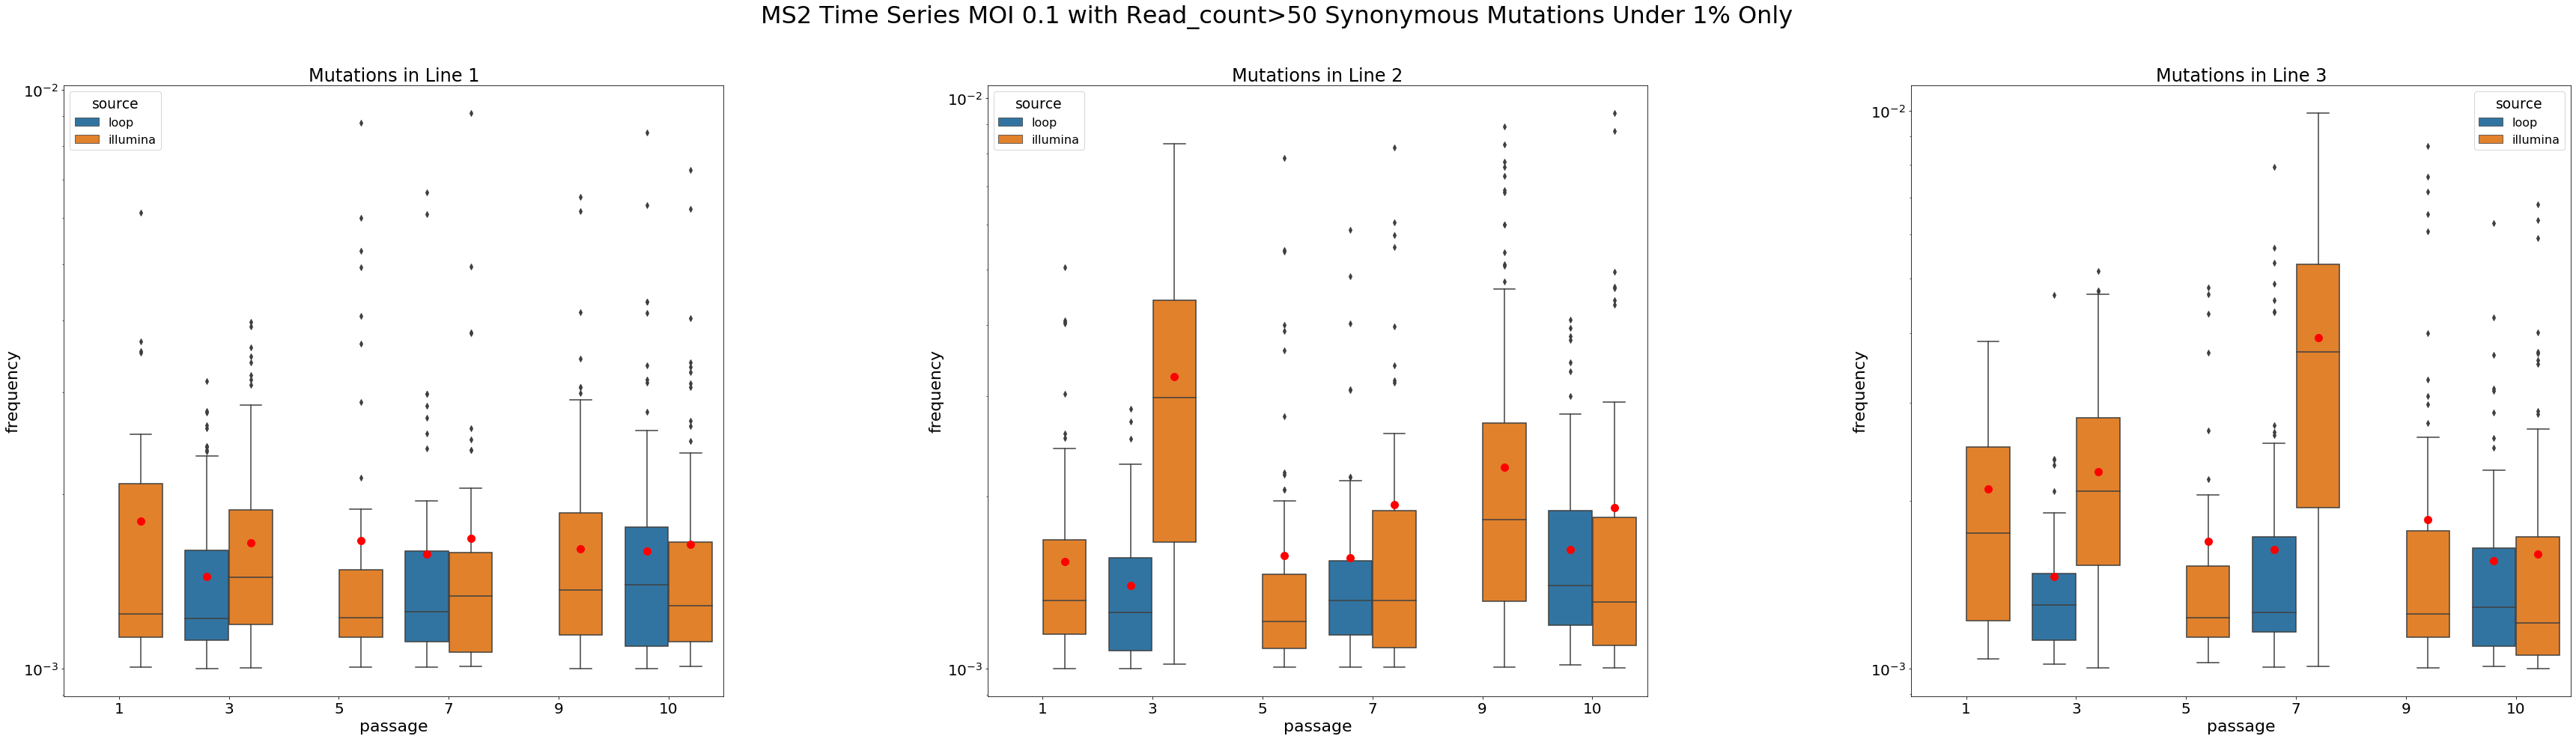

In [59]:
syn_01 = just_syn[just_syn.frequency<0.01]
mutations_box_plots(syn_01, 
                    "MS2 Time Series MOI 0.1 with Read_count>50 Synonymous Mutations Under 1% Only", 
                    log_scale=True)

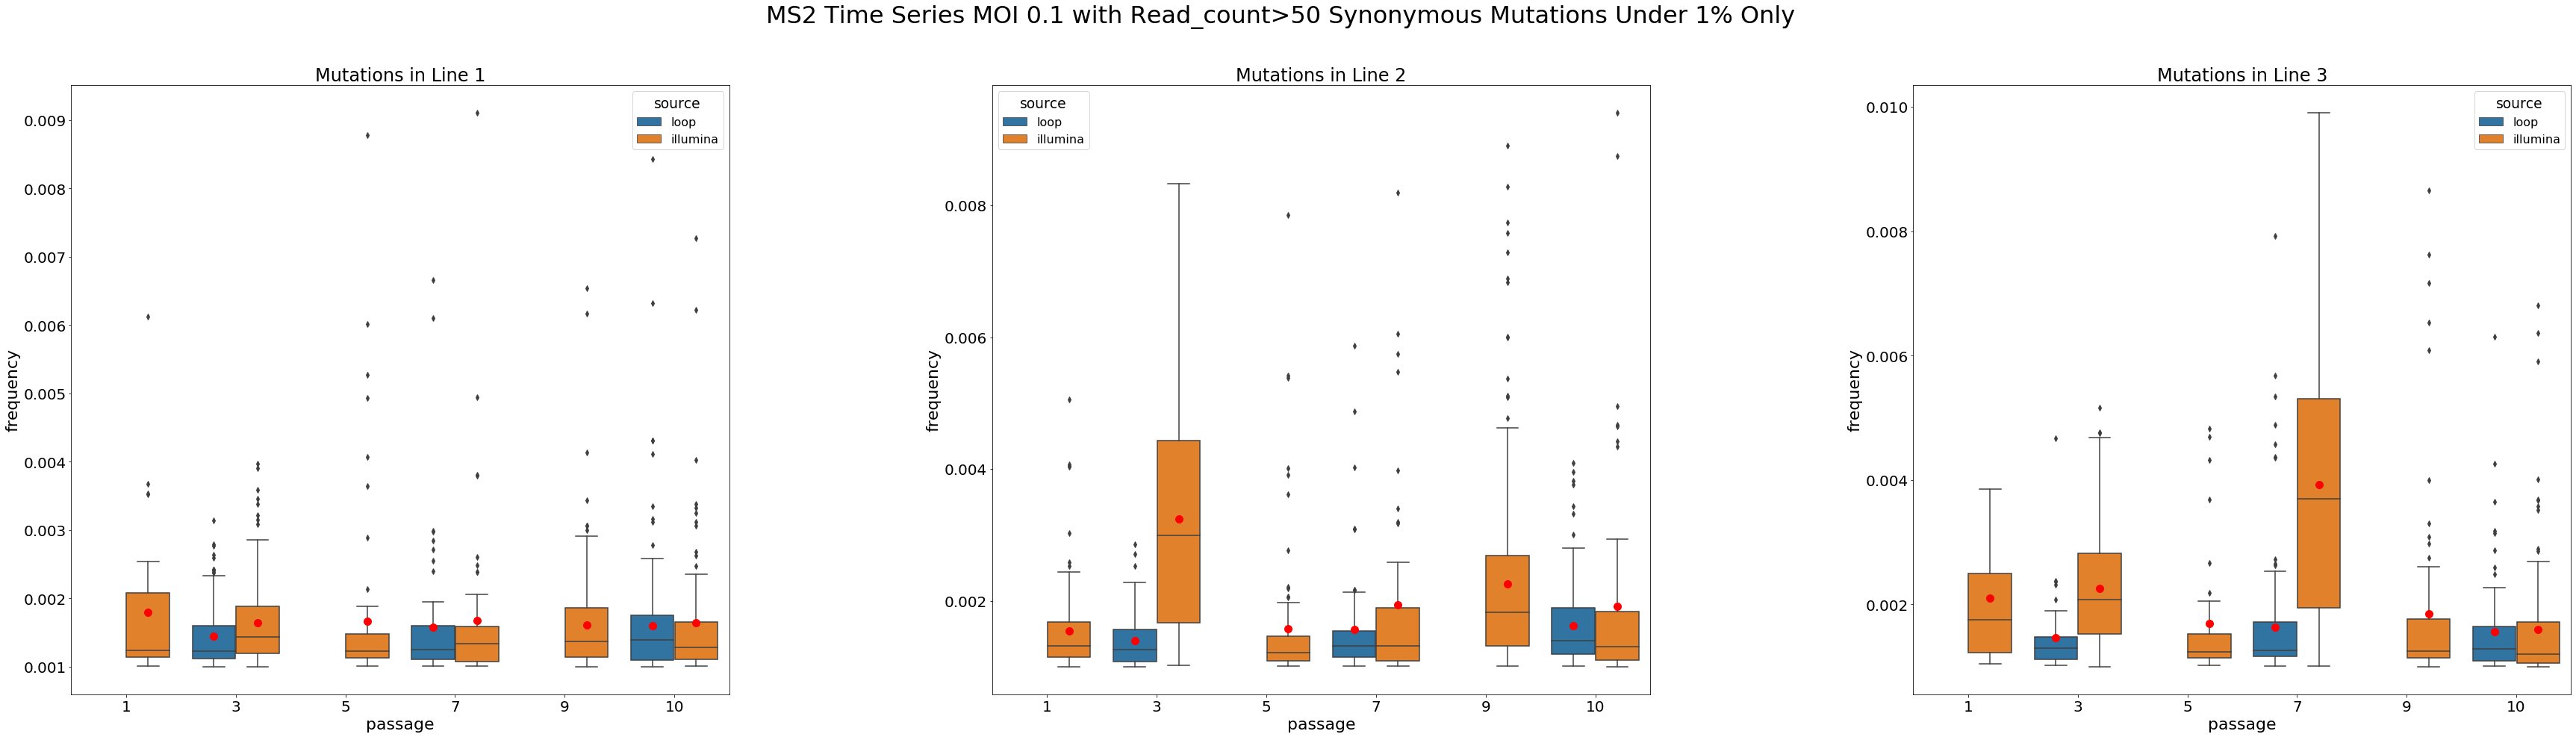

In [60]:
syn_01 = just_syn[just_syn.frequency<0.01]
mutations_box_plots(syn_01, 
                    "MS2 Time Series MOI 0.1 with Read_count>50 Synonymous Mutations Under 1% Only", 
                    log_scale=False)

In [47]:
syn_01.groupby(['km','passage','source']).frequency.median()

km  passage  source  
1   1        illumina    0.001242
    3        illumina    0.001439
             loop        0.001222
    5        illumina    0.001225
    7        illumina    0.001334
             loop        0.001254
    9        illumina    0.001366
    10       illumina    0.001285
             loop        0.001396
2   1        illumina    0.001317
    3        illumina    0.002988
             loop        0.001252
    5        illumina    0.001208
    7        illumina    0.001318
             loop        0.001315
    9        illumina    0.001825
    10       illumina    0.001308
             loop        0.001399
3   1        illumina    0.001748
    3        illumina    0.002080
             loop        0.001300
    5        illumina    0.001233
    7        illumina    0.003700
             loop        0.001261
    9        illumina    0.001252
    10       illumina    0.001207
             loop        0.001287
Name: frequency, dtype: float64

In [49]:
from scipy.stats import ks_2samp

In [50]:
def compare_dists(df):
    loop = df[df.source=='loop']
    illumina = df[df.source=='illumina']
    if loop.empty:
        return
    return ks_2samp(loop.frequency, illumina.frequency)

In [53]:
mutations[(mutations.km==1) & (mutations.passage==7)].groupby('source').frequency.median()

source
illumina    0.001396
loop        0.001397
Name: frequency, dtype: float64

In [54]:
mutations.groupby(['km', 'passage']).apply(lambda df: compare_dists(df))

km  passage
1   1                                                   None
    3          (0.22656876222594163, 2.2359114559833415e-11)
    5                                                   None
    7              (0.07302690582959641, 0.5923082226830199)
    9                                                   None
    10            (0.160275991711704, 0.0022275768531884177)
2   1                                                   None
    3           (0.5406709364331462, 1.3322676295501878e-15)
    5                                                   None
    7            (0.15382613222280062, 0.046531791129991174)
    9                                                   None
    10         (0.19617653190106563, 0.00017339523899895237)
3   1                                                   None
    3           (0.3514686751758074, 1.7544839820664476e-20)
    5                                                   None
    7           (0.6215541762888936, 3.3306690738754696e-16)
    9       